# Ergodic MMD - Kernel Learning

In [14]:
# set python to pick up local directory
from pathlib import Path
import sys
import os
path_root = str(Path(os.getcwd()).parents[0])
package_root = str(Path(os.getcwd()).parents[1])
sys.path.append(path_root)
sys.path.append(package_root)

# auto reload
%reload_ext autoreload
%autoreload 2

# hush
import warnings
warnings.simplefilter('always', category=FutureWarning)

In [15]:
from jax import config
config.update("jax_enable_x64", True)

In [16]:
import open3d as o3d
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

In [17]:
import jax
import jax.numpy as jnp
from jax.lib import xla_bridge
import equinox as eqx
from tensorflow_probability.substrates.jax import distributions as tfd
import jaxopt, optax
from tinygp.kernels.stationary import ExpSquared

In [18]:
from emmd.target_distributions import Uniform2D, TriModal2D
from emmd.utils import grid, bin_data
from emmd.mesh_distributions import SphereMesh, BunnyMesh
from emmd.mmd import ImpCloudMMD
from emmd.transforms import Transform, ARD, DeepCK 
from emmd.kernels import RFF
from emmd.train import trainable, train_mmd_kernel, train_mmd_kernel_lgcp, \
    train_mmd, train_mmd_kernel_gp, train_mmd_kernel_score
from emmd.gp import gp_pred
from emmd.score import ScoreDensity

In [19]:
jax.clear_caches()
print(f"device: {xla_bridge.get_backend().platform}")

device: gpu


In [20]:
key = jax.random.PRNGKey(0)

## Uniform

In [9]:
lb =  jnp.array([0.14,0.15])
ub =  jnp.array([0.91,0.9])
bounds = jnp.array([lb, ub])
n_p = 100
p_init = jnp.linspace(lb, ub, num=n_p, endpoint=True)
samples = grid(bounds, N=20)
sample_grid = grid(bounds, N=20, flatten=False)

In [9]:
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

#### RBF

In [10]:
key = jax.random.PRNGKey(2024)
ls = jnp.sqrt(0.05)
uni2d_rbf = Transform(ARD(jnp.ones(2) * ls), ExpSquared())
uni2d_mmd_init = ImpCloudMMD(uni2d_rbf, p_init)  # uniform px by default

epoch 0,loss: 0.4395809034346837
epoch 100,loss: 0.44152878400927364
epoch 200,loss: 0.4425140445799481
epoch 300,loss: 0.4429632652530918
epoch 400,loss: 0.4431448671321671
epoch 500,loss: 0.4432086388179799
epoch 600,loss: 0.4432278075031838
epoch 700,loss: 0.4432326908036047
epoch 800,loss: 0.443233738115345
epoch 900,loss: 0.4432339264546491


<Axes: >

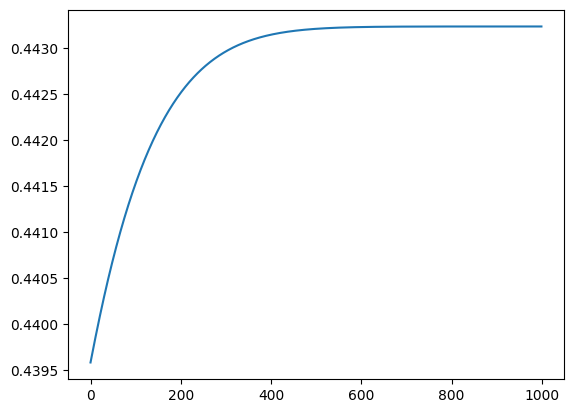

In [11]:
uni2d_mmd, uni2d_loss = train_mmd_kernel(
    key, uni2d_mmd_init, samples, epochs=1000, to_train=lambda t: [t.k.transform.scale], ls=1e-2,
    verbose=True, print_iter=100, shuffle=True
)
sns.lineplot(x=jnp.arange(len(uni2d_loss)), y=uni2d_loss)

epoch 0,loss: 0.006493166885980731
epoch 100,loss: 0.0049386883406842205
epoch 200,loss: 0.0018614014173893093
epoch 300,loss: 0.001854461159511156
epoch 400,loss: 0.0009355741315149463
epoch 500,loss: 0.0008417151375863866
epoch 600,loss: 0.0004980341363758078
epoch 700,loss: 0.00040827648480890044
epoch 800,loss: 0.00020636532492974285
epoch 900,loss: 0.00019702822102665718
epoch 1000,loss: 0.00020969414268894038
epoch 1100,loss: 0.00012743111935519663
epoch 1200,loss: 0.00012332927286036466
epoch 1300,loss: 8.485465277590504e-05
epoch 1400,loss: 7.405607881950244e-05
epoch 1500,loss: 7.554942337393428e-05
epoch 1600,loss: 3.5684744429186066e-05
epoch 1700,loss: 3.3566825006527135e-05
epoch 1800,loss: 2.840271779725595e-05
epoch 1900,loss: 2.4758539225983034e-05


<Axes: >

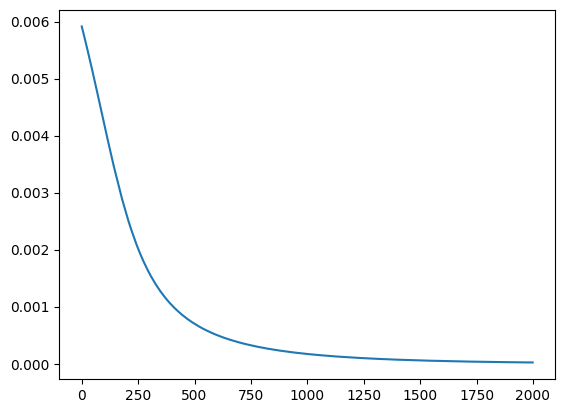

In [12]:
uni2d_mmd2, uni2d_loss2 = train_mmd_kernel_permutation(
    key, uni2d_mmd_init, samples, epochs=2000, to_train=lambda t: [t.k.transform.scale], ls=1e-2,
    verbose=True, print_iter=100, shuffle=True
)
sns.lineplot(x=jnp.arange(len(uni2d_loss2)), y=uni2d_loss2)

epoch 0,loss: 4.820192057839259e-06
epoch 100,loss: 4.456449261812532e-06
epoch 200,loss: 3.97944583479267e-06
epoch 300,loss: 3.329765024760415e-06
epoch 400,loss: 2.4768645879926446e-06
epoch 500,loss: 1.6526630725881646e-06
epoch 600,loss: 1.0882404403529078e-06
epoch 700,loss: 7.455572957041779e-07
epoch 800,loss: 5.355490582616955e-07
epoch 900,loss: 4.0097200559102544e-07
epoch 1000,loss: 3.1054123921172983e-07
epoch 1100,loss: 2.4715946683595505e-07
epoch 1200,loss: 2.011199877121129e-07
epoch 1300,loss: 1.6665926665459203e-07
epoch 1400,loss: 1.4020570188481253e-07
epoch 1500,loss: 1.1945947467512e-07
epoch 1600,loss: 1.0288884007441528e-07
epoch 1700,loss: 8.944298971567662e-08
epoch 1800,loss: 7.83821049366534e-08
epoch 1900,loss: 6.917328832384468e-08


<Axes: >

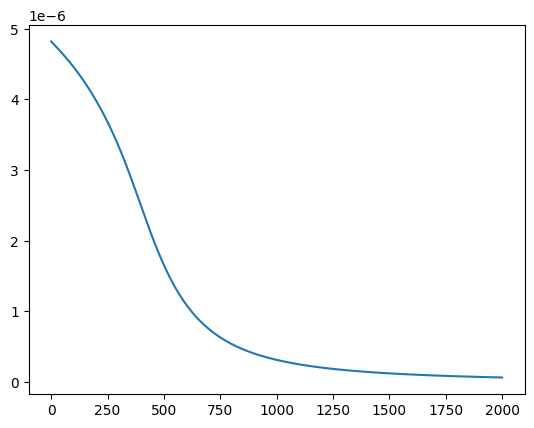

In [13]:
uni2d_mmd3, uni2d_loss3 = train_mmd_grad_kernel(
    key, uni2d_mmd_init, samples, epochs=2000, to_train=lambda t: [t.k.transform.scale], ls=1e-2,
    verbose=True, print_iter=100, shuffle=True
)
sns.lineplot(x=jnp.arange(len(uni2d_loss3)), y=uni2d_loss3)

epoch 0,loss: 4.820192057839259e-06
epoch 100,loss: 4.456449261812532e-06
epoch 200,loss: 3.97944583479267e-06
epoch 300,loss: 3.329765024760415e-06
epoch 400,loss: 2.4768645879926446e-06
epoch 500,loss: 1.6526630725881646e-06
epoch 600,loss: 1.0882404403529078e-06
epoch 700,loss: 7.455572957041779e-07
epoch 800,loss: 5.355490582616955e-07
epoch 900,loss: 4.0097200559102544e-07
epoch 1000,loss: 3.1054123921172983e-07
epoch 1100,loss: 2.4715946683595505e-07
epoch 1200,loss: 2.011199877121129e-07
epoch 1300,loss: 1.6665926665459203e-07
epoch 1400,loss: 1.4020570188481253e-07
epoch 1500,loss: 1.1945947467512e-07
epoch 1600,loss: 1.0288884007441528e-07
epoch 1700,loss: 8.944298971567662e-08
epoch 1800,loss: 7.83821049366534e-08
epoch 1900,loss: 6.917328832384468e-08


<Axes: >

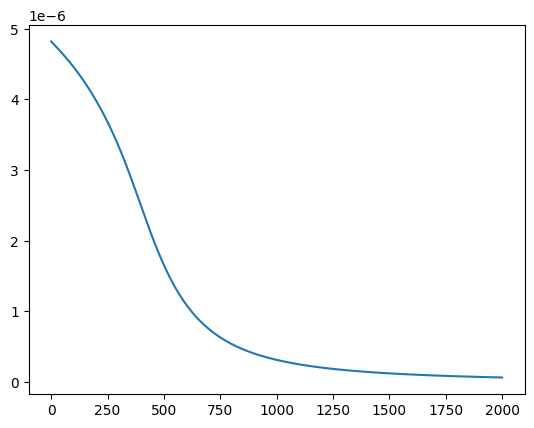

In [14]:
uni2d_mmd3, uni2d_loss3 = train_mmd_grad_kernel(
    key, uni2d_mmd_init, samples, epochs=2000, to_train=lambda t: [t.k.transform.scale], ls=1e-2,
    verbose=True, print_iter=100, shuffle=True
)
sns.lineplot(x=jnp.arange(len(uni2d_loss3)), y=uni2d_loss3)

In [15]:
uni2d_mmd_untrained, uni2d_mmd_untrained_state = train_mmd(key, uni2d_mmd_init, samples, bounds, aux_loss=traj_loss_fn)
uni2d_mmd_trained, uni2d_mmd_trained_state = train_mmd(key, uni2d_mmd, samples, bounds, aux_loss=traj_loss_fn)
uni2d_mmd_trained2, uni2d_mmd_trained_state2 = train_mmd(key, uni2d_mmd2, samples, bounds, aux_loss=traj_loss_fn)
uni2d_mmd_trained3, uni2d_mmd_trained_state3 = train_mmd(key, uni2d_mmd3, samples, bounds, aux_loss=traj_loss_fn)

{}
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 9.638901011929418e-06 Stepsize:1.0  Decrease Error:0.0  Curvature Error:9.638901011929418e-06 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 7.498325919163878e-05 Stepsize:1.0  Decrease Error:0.0  Curvature Error:7.498325919163878e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.00017726512220365737 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.00017726512220365737 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0005463747464602119 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0005463747464602119 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0019828366639683785 Stepsi

In [ ]:
uni2d_mmd_untrained_state.value, uni2d_mmd_trained_state.value, uni2d_mmd_trained_state2.value, uni2d_mmd_trained_state3.value, uni2d_mmd_trained_state4.value

(Array(0.00132861, dtype=float64),
 Array(0.00246344, dtype=float64),
 Array(0.00011523, dtype=float64),
 Array(0.00096526, dtype=float64),
 Array(0.00131469, dtype=float64))

In [ ]:
uni2d_mmd_trained.k.transform._scale, uni2d_mmd_trained2.k.transform._scale, uni2d_mmd_trained3.k.transform._scale, uni2d_mmd_trained4.k.transform._scale

(Array([0.16769269, 0.16272062], dtype=float64),
 Array([6.13165174, 6.49058747], dtype=float64),
 Array([0.56004518, 1.12662415], dtype=float64),
 Array([0.2236068, 0.2236068], dtype=float64))

<Axes: >

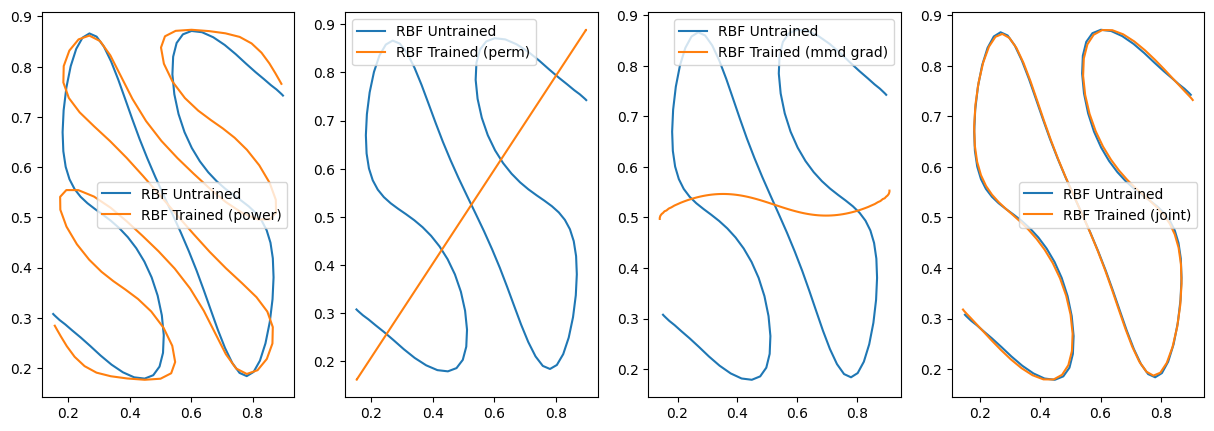

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
# sns.scatterplot(x=samples[:, 0], y=samples[:,1], ax=ax[0])
# sns.lineplot(x=p_init[:, 0], y=p_init[:,1], label="Init", ax=ax[0])
sns.lineplot(x=uni2d_mmd_untrained.w[:, 0], y=uni2d_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[0], sort=False)
sns.lineplot(x=uni2d_mmd_trained.w[:, 0], y=uni2d_mmd_trained.w[:,1], label="RBF Trained (power)", ax=ax[0], sort=False)
sns.lineplot(x=uni2d_mmd_untrained.w[:, 0], y=uni2d_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[1], sort=False)
sns.lineplot(x=uni2d_mmd_trained2.w[:, 0], y=uni2d_mmd_trained2.w[:,1], label="RBF Trained (perm)", ax=ax[1], sort=False)
sns.lineplot(x=uni2d_mmd_untrained.w[:, 0], y=uni2d_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[2], sort=False)
sns.lineplot(x=uni2d_mmd_trained3.w[:, 0], y=uni2d_mmd_trained3.w[:,1], label="RBF Trained (mmd grad)", ax=ax[2], sort=False)
sns.lineplot(x=uni2d_mmd_untrained.w[:, 0], y=uni2d_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[3], sort=False)
sns.lineplot(x=uni2d_mmd_trained4.w[:, 0], y=uni2d_mmd_trained4.w[:,1], label="RBF Trained (joint)", ax=ax[3], sort=False)

#### RFF

In [ ]:
uni2d_rff = Transform(ARD(jnp.ones(2) * ls), RFF(key, R=100, d=2))
uni2d_mmd_rff_init = ImpCloudMMD(uni2d_rff, p_init)  # uniform px by default

epoch 0,loss: 0.43377258144359065
epoch 100,loss: 0.45572758038289807
epoch 200,loss: 0.46787468464562293
epoch 300,loss: 0.47528100557983627
epoch 400,loss: 0.47999221930598124
epoch 500,loss: 0.483091420652591
epoch 600,loss: 0.48523796060269975
epoch 700,loss: 0.4867418953743233
epoch 800,loss: 0.48777870485801533
epoch 900,loss: 0.48851248955408444
epoch 1000,loss: 0.48903005901612506
epoch 1100,loss: 0.4893119911697834
epoch 1200,loss: 0.4894940730440418
epoch 1300,loss: 0.4896139034642866
epoch 1400,loss: 0.4896958524828346
epoch 1500,loss: 0.4897582930605633
epoch 1600,loss: 0.4898239251334485
epoch 1700,loss: 0.489966627722174
epoch 1800,loss: 0.49021099659393574
epoch 1900,loss: 0.4904903670196097


<Axes: >

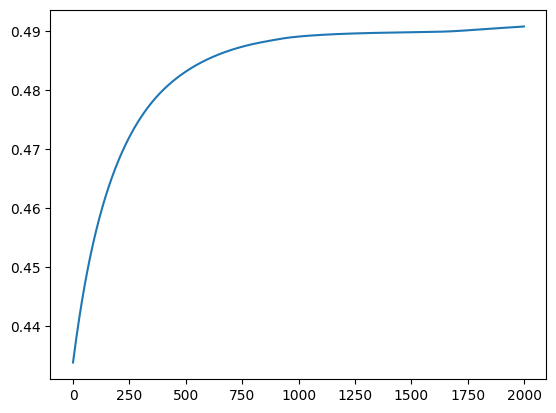

In [ ]:
uni2d_mmd_rff, uni2d_rff_loss = train_mmd_kernel(
    key, uni2d_mmd_rff_init, samples, epochs=2000, to_train=lambda t: [t.k.transform.scale, t.k.kernel.w], 
    ls=1e-2, verbose=True, print_iter=100, shuffle=True
)
sns.lineplot(x=jnp.arange(len(uni2d_rff_loss)), y=uni2d_rff_loss)

epoch 0,loss: 6.833378256428244e-06
epoch 100,loss: 2.2104810133501654e-06
epoch 200,loss: 3.985704996837267e-07
epoch 300,loss: 1.0658967270255981e-07
epoch 400,loss: 3.664623035332782e-08
epoch 500,loss: 1.4479102630637509e-08
epoch 600,loss: 6.257613423853666e-09
epoch 700,loss: 2.907720600797689e-09
epoch 800,loss: 1.4536289055803605e-09
epoch 900,loss: 7.863422261338834e-10
epoch 1000,loss: 4.610794541023482e-10
epoch 1100,loss: 2.9225735859497563e-10
epoch 1200,loss: 1.9995463246990014e-10
epoch 1300,loss: 1.4795316669306333e-10
epoch 1400,loss: 1.184398934133482e-10
epoch 1500,loss: 1.0182217822784019e-10
epoch 1600,loss: 9.259604549692231e-11
epoch 1700,loss: 8.752940851809678e-11
epoch 1800,loss: 8.473695502684387e-11
epoch 1900,loss: 8.314386639279507e-11


<Axes: >

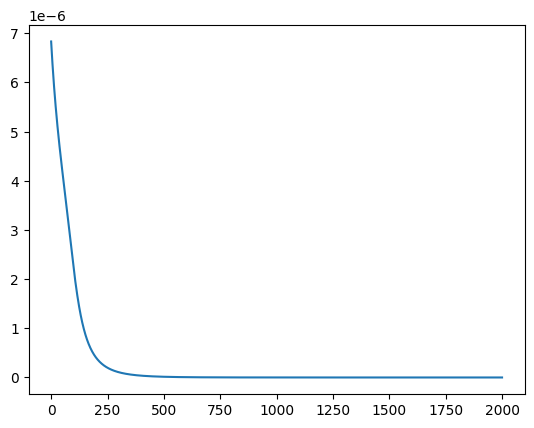

In [ ]:
uni2d_mmd_rff2, uni2d_rff_loss2 = train_mmd_grad_kernel(
    key, uni2d_mmd_rff_init, samples, epochs=2000, to_train=lambda t: [t.k.transform.scale, t.k.kernel.w], 
    ls=1e-2, verbose=True, print_iter=100, shuffle=True, aux_loss=traj_loss_fn
)
sns.lineplot(x=jnp.arange(len(uni2d_rff_loss2)), y=uni2d_rff_loss2)

In [ ]:
uni2d_mmd_rff_untrained, uni2d_mmd_rff_untrained_state = train_mmd(key, uni2d_mmd_rff_init, samples, bounds, aux_loss=traj_loss_fn)
uni2d_mmd_rff_trained, uni2d_mmd_rff_trained_state = train_mmd(key, uni2d_mmd_rff, samples, bounds, aux_loss=traj_loss_fn)
uni2d_mmd_rff_trained2, uni2d_mmd_rff_trained_state2 = train_mmd(key, uni2d_mmd_rff2, samples, bounds, aux_loss=traj_loss_fn)

In [ ]:
uni2d_mmd_rff_untrained_state.value, uni2d_mmd_rff_trained_state.value, uni2d_mmd_rff_trained_state2.value

(Array(0.00123474, dtype=float64),
 Array(0.00095924, dtype=float64),
 Array(0.0017517, dtype=float64))

#### Deep Kernel

In [ ]:
layers = [2, 10, 10, 10, 4]
char_rbf = Transform(ARD(jnp.ones(2) * ls), ExpSquared())
uni2d_deep_k = CharDeepKernel(key, layers, char_rbf)

uni2d_mmd_deep_init = ImpCloudMMD(uni2d_deep_k, p_init)  # uniform px by default
deep_param_fn = lambda t: [t.k.nnk.transform, t.k.ck.transform.scale, t.k.epsilon]
# deep_param_fn = lambda t: [t.k.nnk.transform.layers, t.k.nnk.transform.scale]

epoch 0,loss: 0.43958193636371756
epoch 100,loss: 0.4467127230980838
epoch 200,loss: 0.47143490063869675
epoch 300,loss: 0.47739241185605336
epoch 400,loss: 0.4805714856154143
epoch 500,loss: 0.48292816565561125
epoch 600,loss: 0.4847951182168748
epoch 700,loss: 0.4863551134934717
epoch 800,loss: 0.48771970500249323
epoch 900,loss: 0.48897991341575026
epoch 1000,loss: 0.49011864595054366
epoch 1100,loss: 0.4911869669299559
epoch 1200,loss: 0.4921727660190289
epoch 1300,loss: 0.49299885682955397
epoch 1400,loss: 0.4936263618500392
epoch 1500,loss: 0.49410530796339397
epoch 1600,loss: 0.49449131091571175
epoch 1700,loss: 0.4948150435382102
epoch 1800,loss: 0.4950940121176918
epoch 1900,loss: 0.4953379191878622
epoch 2000,loss: 0.49555317816396827
epoch 2100,loss: 0.49574428140471444
epoch 2200,loss: 0.49591535493704647
epoch 2300,loss: 0.4960685459395078
epoch 2400,loss: 0.4962069009839818
epoch 2500,loss: 0.4963318623902737
epoch 2600,loss: 0.49644489256688185
epoch 2700,loss: 0.4965483

<Axes: >

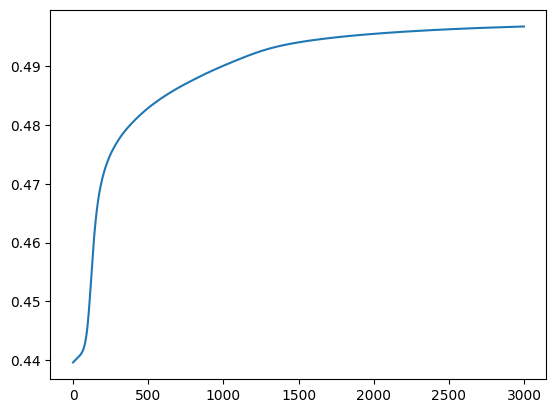

In [ ]:
uni2d_mmd_deep, uni2d_deep_loss = train_mmd_kernel(
    key, uni2d_mmd_deep_init, samples, epochs=3000, to_train=deep_param_fn, 
    verbose=True, print_iter=100, shuffle=True, opt=optax.adam(1e-3)
)
sns.lineplot(x=jnp.arange(len(uni2d_deep_loss)), y=uni2d_deep_loss)

epoch 0,loss: 4.8198733564565666e-06
epoch 100,loss: 4.451200160354166e-06
epoch 200,loss: 2.5605583096476727e-06
epoch 300,loss: 9.607909250503307e-07
epoch 400,loss: 5.812862104745195e-07
epoch 500,loss: 3.8602038178672565e-07
epoch 600,loss: 2.723699063441534e-07
epoch 700,loss: 2.0147936360853692e-07
epoch 800,loss: 1.5455637429593735e-07
epoch 900,loss: 1.220029478860064e-07
epoch 1000,loss: 9.854647046234102e-08
epoch 1100,loss: 8.11097975967107e-08
epoch 1200,loss: 6.780740172290135e-08
epoch 1300,loss: 5.7434579475304524e-08
epoch 1400,loss: 4.9194028562023486e-08
epoch 1500,loss: 4.254140989639408e-08
epoch 1600,loss: 3.7095298556311035e-08
epoch 1700,loss: 3.258206334982963e-08
epoch 1800,loss: 2.8801401916762287e-08
epoch 1900,loss: 2.5603980880169272e-08
epoch 2000,loss: 2.2876618876470533e-08
epoch 2100,loss: 2.053231506728182e-08
epoch 2200,loss: 1.8503311335273207e-08
epoch 2300,loss: 1.6736171210581923e-08
epoch 2400,loss: 1.5188327520043794e-08
epoch 2500,loss: 1.38255

<Axes: >

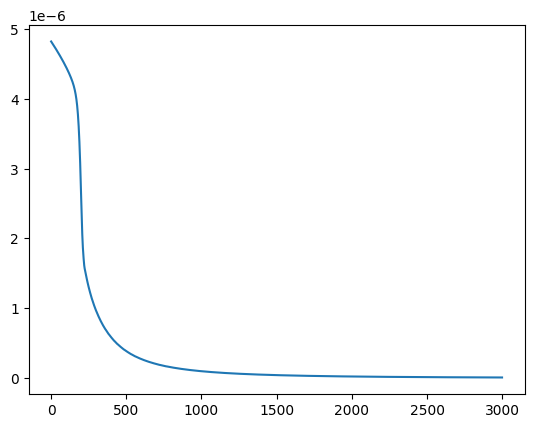

In [ ]:
uni2d_mmd_deep2, uni2d_deep_loss2 = train_mmd_grad_kernel(
    key, uni2d_mmd_deep_init, samples, epochs=3000, to_train=deep_param_fn, 
    verbose=True, print_iter=100, shuffle=True, opt=optax.adam(1e-3)
)
sns.lineplot(x=jnp.arange(len(uni2d_deep_loss2)), y=uni2d_deep_loss2)

In [ ]:
uni2d_mmd_deep_untrained, uni2d_mmd_deep_untrained_state = train_mmd(key, uni2d_mmd_deep_init, samples, bounds, aux_loss=traj_loss_fn)
uni2d_mmd_deep_trained, uni2d_mmd_deep_trained_state = train_mmd(key, uni2d_mmd_deep, samples, bounds, aux_loss=traj_loss_fn)
uni2d_mmd_deep_trained2, uni2d_mmd_deep_trained_state2 = train_mmd(key, uni2d_mmd_deep2, samples, bounds, aux_loss=traj_loss_fn)

In [ ]:
uni2d_mmd_deep_untrained_state.value, uni2d_mmd_deep_trained_state.value, uni2d_mmd_deep_trained_state2.value

(Array(0.00132872, dtype=float64),
 Array(0.00056827, dtype=float64),
 Array(0.00064012, dtype=float64))

#### Plots

<Axes: >

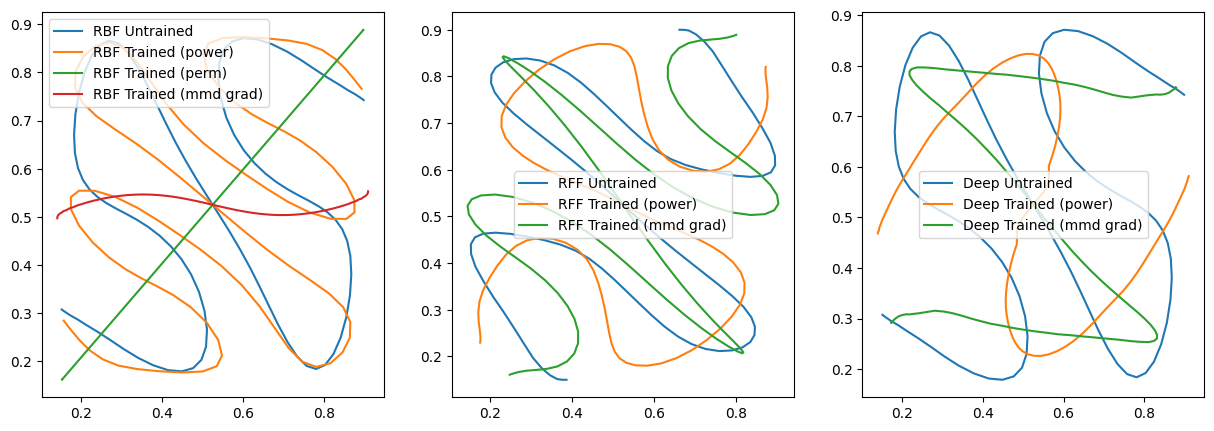

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# sns.scatterplot(x=samples[:, 0], y=samples[:,1], ax=ax[0])
# sns.lineplot(x=p_init[:, 0], y=p_init[:,1], label="Init", ax=ax[0])
sns.lineplot(x=uni2d_mmd_untrained.w[:, 0], y=uni2d_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[0], sort=False)
sns.lineplot(x=uni2d_mmd_trained.w[:, 0], y=uni2d_mmd_trained.w[:,1], label="RBF Trained (power)", ax=ax[0], sort=False)
sns.lineplot(x=uni2d_mmd_trained2.w[:, 0], y=uni2d_mmd_trained2.w[:,1], label="RBF Trained (perm)", ax=ax[0], sort=False)
sns.lineplot(x=uni2d_mmd_trained3.w[:, 0], y=uni2d_mmd_trained3.w[:,1], label="RBF Trained (mmd grad)", ax=ax[0], sort=False)

# sns.scatterplot(x=samples[:, 0], y=samples[:,1], ax=ax[1])
# sns.lineplot(x=p_init[:, 0], y=p_init[:,1], label="Init", ax=ax[1])
sns.lineplot(x=uni2d_mmd_rff_untrained.w[:, 0], y=uni2d_mmd_rff_untrained.w[:,1], label="RFF Untrained", ax=ax[1], sort=False)
sns.lineplot(x=uni2d_mmd_rff_trained.w[:, 0], y=uni2d_mmd_rff_trained.w[:,1], label="RFF Trained (power)", ax=ax[1], sort=False)
sns.lineplot(x=uni2d_mmd_rff_trained2.w[:, 0], y=uni2d_mmd_rff_trained2.w[:,1], label="RFF Trained (mmd grad)", ax=ax[1], sort=False)

sns.lineplot(x=uni2d_mmd_deep_untrained.w[:, 0], y=uni2d_mmd_deep_untrained.w[:,1], label="Deep Untrained", ax=ax[2], sort=False)
sns.lineplot(x=uni2d_mmd_deep_trained.w[:, 0], y=uni2d_mmd_deep_trained.w[:,1], label="Deep Trained (power)", ax=ax[2], sort=False)
sns.lineplot(x=uni2d_mmd_deep_trained2.w[:, 0], y=uni2d_mmd_deep_trained2.w[:,1], label="Deep Trained (mmd grad)", ax=ax[2], sort=False)

<Axes: >

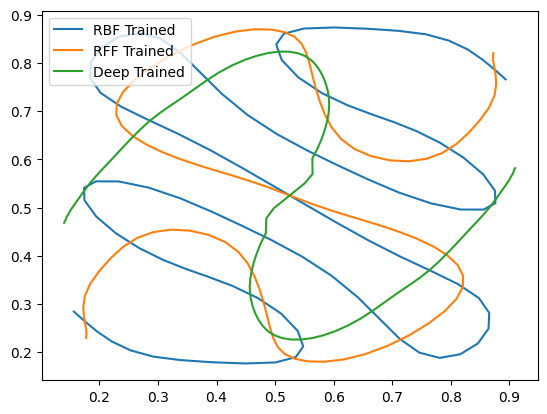

In [ ]:
sns.lineplot(x=uni2d_mmd_trained.w[:, 0], y=uni2d_mmd_trained.w[:,1], label="RBF Trained", sort=False)
sns.lineplot(x=uni2d_mmd_rff_trained.w[:, 0], y=uni2d_mmd_rff_trained.w[:,1], label="RFF Trained", sort=False)
sns.lineplot(x=uni2d_mmd_deep_trained.w[:, 0], y=uni2d_mmd_deep_trained.w[:,1], label="Deep Trained", sort=False)

Array(0.00118789, dtype=float64)

#### Plot Kernels

In [ ]:
test_pt = jnp.mean(bounds, axis=0)[None, :]
test_grid = grid(bounds, N=100, flatten=True)

<Axes: >

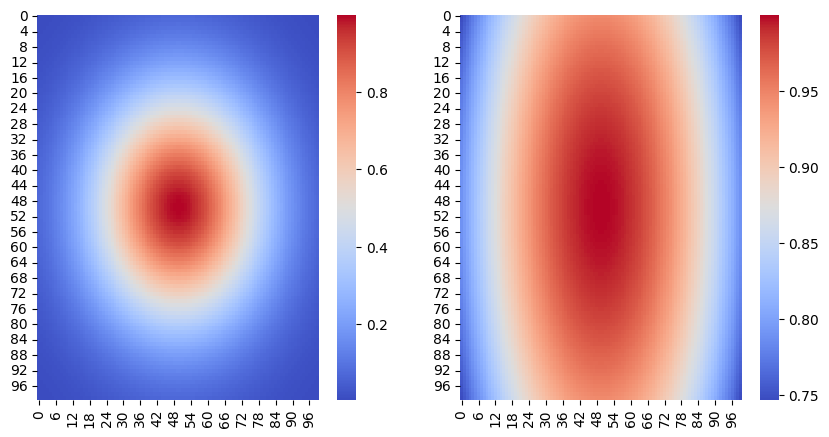

In [ ]:
K_rbf = uni2d_mmd_trained.k(test_pt, test_grid).reshape(100, 100)
K_rbf2 = uni2d_mmd_trained2.k(test_pt, test_grid).reshape(100, 100)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(K_rbf, ax=ax[0], cmap=cm.coolwarm)
sns.heatmap(K_rbf2, ax=ax[1], cmap=cm.coolwarm)

<Axes: >

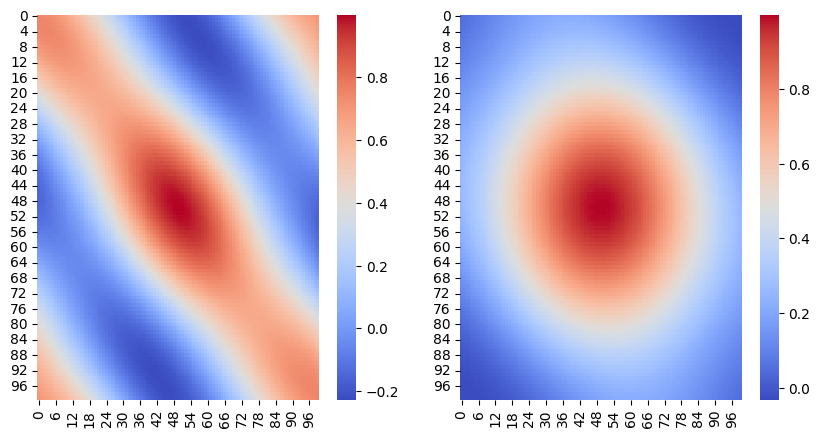

In [ ]:
K_rff = uni2d_mmd_rff_trained.k(test_pt, test_grid).reshape(100, 100)
K_rff2 = uni2d_mmd_rff_trained2.k(test_pt, test_grid).reshape(100, 100)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(K_rff, ax=ax[0], cmap=cm.coolwarm)
sns.heatmap(K_rff2, ax=ax[1], cmap=cm.coolwarm)

In [ ]:
K_rff = uni2d_mmd_rff_trained.k(test_pt, test_grid).reshape(100, 100)
K_rff2 = uni2d_mmd_rff_trained2.k(test_pt, test_grid).reshape(100, 100)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(K_rff, ax=ax[0], cmap=cm.coolwarm)
sns.heatmap(K_rff2, ax=ax[1], cmap=cm.coolwarm)

In [ ]:
def ergodic_metric(particles, samples, mesh):
    pass

In [ ]:
ks_dim1, ks_dim2 = jnp.meshgrid(
    jnp.arange(100), jnp.arange(100)
)
ks = jnp.array([ks_dim1.ravel(), ks_dim2.ravel()]).T  # this is the set of all index vectors

In [ ]:
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
erg_metric = np.sum(lamk_list * np.square(coefficients - traj_coefficients))

Array([[ 0,  0],
       [ 1,  0],
       [ 2,  0],
       ...,
       [97, 99],
       [98, 99],
       [99, 99]], dtype=int64)

## 2D GMM

In [21]:
key = jax.random.PRNGKey(0)

In [22]:
def traj_loss_fn(particles):
    return jnp.mean(jnp.sum((particles[1:]-particles[:-1])**2, axis=1))

In [23]:
w = jnp.array([0.25, 0.75])
mu = jnp.array([[0.15, 0.15], [0.85, 0.85]])
sigma = jnp.array([[0.05, 0.1],[0.1, 0.05]])

gmm = tfd.Mixture(
    cat=tfd.Categorical(probs=w),
    components=[tfd.MultivariateNormalDiag(m, s) for m, s in zip(mu, sigma)]
)
gmm_samples = gmm.sample(1000, seed=key)

<Axes: >

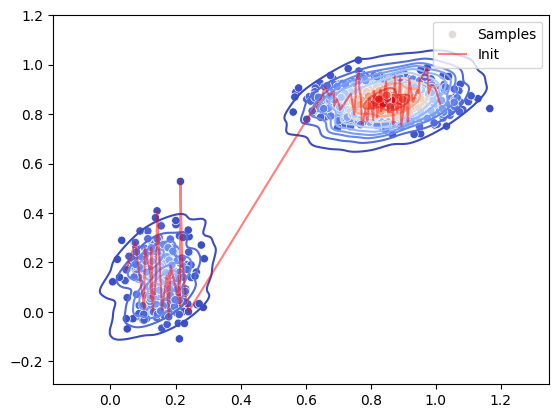

In [24]:
bounds = jnp.array([[-0.25, -0.25], [1.25, 1.25]])
# traj_init = jax.random.uniform(key, (100, 2), minval=bounds[0], maxval=bounds[1])
traj_init = jax.random.choice(key, gmm_samples, replace=False, shape=(100,))
traj_init = traj_init[traj_init[:, 0].argsort()]
X = grid(bounds, N=40, flatten=True)
y = gmm.prob(X)
ls_init = jnp.sqrt(0.1)

# binned data
n_bins = (40, 40)
centroids, counts, volumes = bin_data(gmm_samples, bounds, n_bins)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=0.6, cmap=cm.coolwarm)
sns.scatterplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], c=gmm.prob(gmm_samples), cmap=cm.coolwarm, label="Samples")
sns.lineplot(x=traj_init[:, 0], y=traj_init[:, 1], c='r', label="Init", sort=False, alpha=0.5)

### RBF

In [25]:
rbf = Transform(ARD(jnp.ones(2) * ls_init), ExpSquared())
rbf_mmd_init = ImpCloudMMD(rbf, traj_init)  # uniform px by default

##### Power Training

epoch 0,loss: -0.7118980957918801
epoch 100,loss: -0.6385988273035035
epoch 200,loss: -0.5670294955812072
epoch 300,loss: -0.49899273445275727
epoch 400,loss: -0.43744241486807156
epoch 500,loss: -0.3849033797967878
epoch 600,loss: -0.3419565866969779
epoch 700,loss: -0.3076005785645609
epoch 800,loss: -0.28030386054597944
epoch 900,loss: -0.25863052751619703
epoch 1000,loss: -0.2414152792019998
epoch 1100,loss: -0.2277448749071409
epoch 1200,loss: -0.21689822514050294
epoch 1300,loss: -0.20829608914010286
epoch 1400,loss: -0.20146782492269502
epoch 1500,loss: -0.19603044132071135
epoch 1600,loss: -0.1916742776870036
epoch 1700,loss: -0.18815154657846608
epoch 1800,loss: -0.1852659327722691
epoch 1900,loss: -0.18286271692903233


<Axes: >

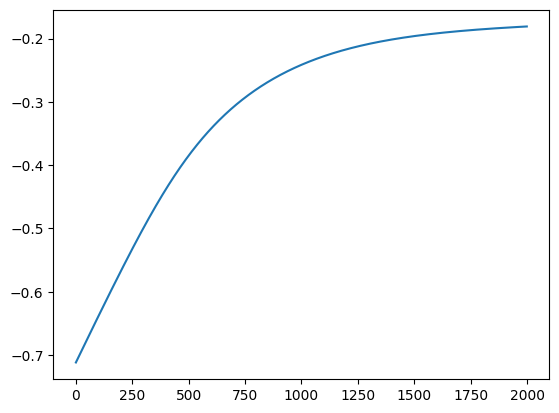

In [44]:
rbf_mmd_power, rbf_loss_power = train_mmd_kernel(
    key, rbf_mmd_init, gmm_samples, epochs=2000, to_train=lambda t: [t.k.transform.scale], ls=1e-2,
    verbose=True, print_iter=100, shuffle=True
)
sns.lineplot(x=jnp.arange(len(rbf_loss_power)), y=rbf_loss_power)

##### GP Training

epoch 0,loss: 983444.4028767402
epoch 100,loss: 821144.0587249406
epoch 200,loss: 668667.7324230745
epoch 300,loss: 536793.9428861516
epoch 400,loss: 424024.9570227055
epoch 500,loss: 324844.5580800445
epoch 600,loss: 247073.05336820203
epoch 700,loss: 190092.39685981564
epoch 800,loss: 146719.12108450802
epoch 900,loss: 112882.51991178824
epoch 1000,loss: 87297.91259684878
epoch 1100,loss: 68494.96947056978
epoch 1200,loss: 54545.74929428356
epoch 1300,loss: 43905.71901235358
epoch 1400,loss: 35605.12480537716


<Axes: >

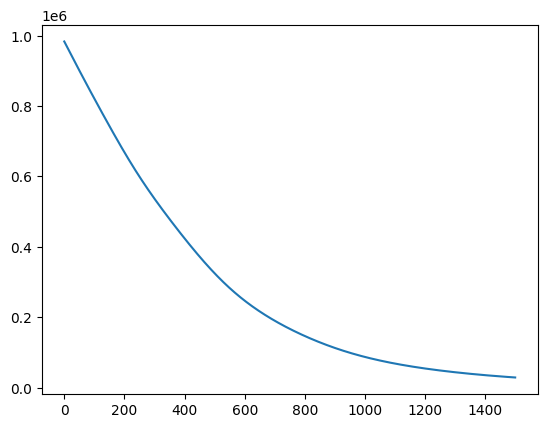

In [45]:
rbf_mmd_gp, rbf_loss_gp = train_mmd_kernel_gp(
    key, rbf_mmd_init, X, y, epochs=1500, to_train=lambda t: [t.k.transform.scale],
    verbose=True, print_iter=100, lr=1e-3, diag=1e-3
)
sns.lineplot(x=jnp.arange(len(rbf_loss_gp)), y=rbf_loss_gp)

In [46]:
y_test = gmm.prob(gmm_samples)
rbf_preds_untrained = gp_pred(rbf_mmd_init.k, X, y, gmm_samples)[0]
rbf_preds = gp_pred(rbf_mmd_gp.k, X, y, gmm_samples)[0]

In [47]:
jnp.mean(jnp.square(rbf_preds_untrained - y_test)), jnp.mean(jnp.square(rbf_preds - y_test))

(Array(20.41042902, dtype=float64), Array(0.15241464, dtype=float64))

<Axes: >

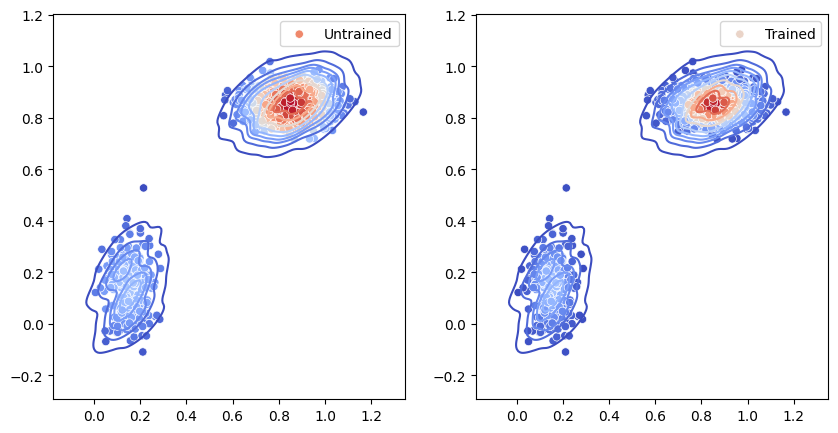

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=0.6, cmap=cm.coolwarm, ax=ax[0])
sns.scatterplot(
    x=gmm_samples[:, 0], y=gmm_samples[:, 1], c=rbf_preds_untrained, cmap=cm.coolwarm, label="Untrained", ax=ax[0]
)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=0.6, cmap=cm.coolwarm, ax=ax[1])
sns.scatterplot(
    x=gmm_samples[:, 0], y=gmm_samples[:, 1], c=rbf_preds, cmap=cm.coolwarm, label="Trained", ax=ax[1]
)

##### Score Matching

In [52]:
score_param_fn = lambda t: [t.k.transform.scale, t.z, t.mu_q, t.sigma_q, t.alpha]
gmm_train = jax.random.choice(key, gmm_samples, replace=False, shape=(500,))

epoch 0,loss: -11.02717102454258
epoch 100,loss: -54.79326629981703
epoch 200,loss: -120.52873104278311
epoch 300,loss: -125.50790269803224
epoch 400,loss: -194.92067849127616
epoch 500,loss: -197.88226995970595
epoch 600,loss: -200.7026668691947
epoch 700,loss: -182.94344805681285
epoch 800,loss: -260.50296463060465
epoch 900,loss: -195.83976681322872
epoch 1000,loss: -211.30497863960628
epoch 1100,loss: -222.4056409683718
epoch 1200,loss: -262.1286084898296
epoch 1300,loss: -234.99500838581
epoch 1400,loss: -207.8870945052491
epoch 1500,loss: -207.21434194455702
epoch 1600,loss: -230.28569709854165
epoch 1700,loss: -232.04728098613546
epoch 1800,loss: -247.6527735313149
epoch 1900,loss: -264.6865375918052


<Axes: >

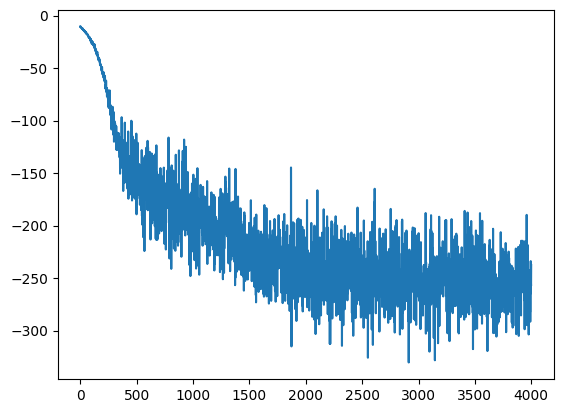

In [54]:
rbf_mmd_score, rbf_mmd_density, rbf_loss_score = train_mmd_kernel_score(
    key, rbf_mmd_init, gmm_train, epochs=2000, to_train=score_param_fn,
    verbose=True, print_iter=100, lr=1e-3, mu=jnp.ones(2) * 0.5, sigma=jnp.ones(2) * 0.1
)
sns.lineplot(x=jnp.arange(len(rbf_loss_score)), y=rbf_loss_score)

In [55]:
rbf_mmd_score.k.transform._scale, rbf_mmd_density.mu_q, jnp.exp(rbf_mmd_density.sigma_q)

(Array([0.15703408, 0.10796688], dtype=float64),
 Array([1.22566635, 0.81176264], dtype=float64),
 Array([0.28694742, 0.17720453], dtype=float64))

<Axes: >

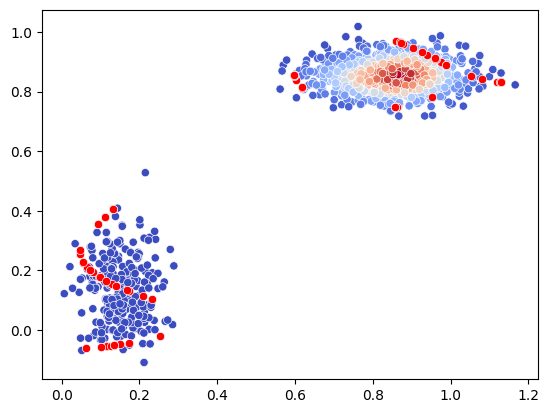

In [56]:
score_pred = jnp.exp(rbf_mmd_density.log_density(gmm_samples))
sns.scatterplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], c=score_pred, cmap=cm.coolwarm)
sns.scatterplot(x=rbf_mmd_density.z[:, 0], y=rbf_mmd_density.z[:, 1], c='r')
# sns.scatterplot(x=z_init[:, 0], y=z_init[:, 1], c='g')

#### Make Trajectory

In [57]:
rbf_mmd_power.k.transform._scale, rbf_mmd_gp.k.transform._scale, rbf_mmd_score.k.transform._scale

(Array([0.10868167, 0.07753761], dtype=float64),
 Array([0.13941163, 0.11893893], dtype=float64),
 Array([0.15703408, 0.10796688], dtype=float64))

In [61]:
#### jaxopt training
opt_params = dict(tol=1e-4, maxiter=500)
# opt_params = None
_bounds = bounds
# _bounds = None

rbf_mmd_untrained, rbf_mmd_untrained_state = train_mmd(
    key, rbf_mmd_init, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
rbf_mmd_power_tr, rbf_mmd_power_state_tr = train_mmd(
    key, rbf_mmd_power, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
rbf_mmd_gp_tr, rbf_mmd_gp_state_tr = train_mmd(
    key, rbf_mmd_gp, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
rbf_mmd_score_tr, rbf_mmd_score_state_tr = train_mmd(
    key, rbf_mmd_score, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)

{'tol': 0.0001, 'maxiter': 500}
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 5.598740242781022e-05 Stepsize:1.0  Decrease Error:0.0  Curvature Error:5.598740242781022e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decre

In [62]:
rbf_mmd_untrained(gmm_samples), rbf_mmd_power_tr(gmm_samples), rbf_mmd_gp_tr(gmm_samples), rbf_mmd_score_tr(gmm_samples)

(Array(0.00025852, dtype=float64),
 Array(0.00049785, dtype=float64),
 Array(0.00045057, dtype=float64),
 Array(0.00045569, dtype=float64))

In [63]:
traj_loss_fn(rbf_mmd_untrained.w), traj_loss_fn(rbf_mmd_power_tr.w), traj_loss_fn(rbf_mmd_gp_tr.w), traj_loss_fn(rbf_mmd_score_tr.w)

(Array(0.00094244, dtype=float64),
 Array(0.00132529, dtype=float64),
 Array(0.00131182, dtype=float64),
 Array(0.00130683, dtype=float64))

<Axes: >

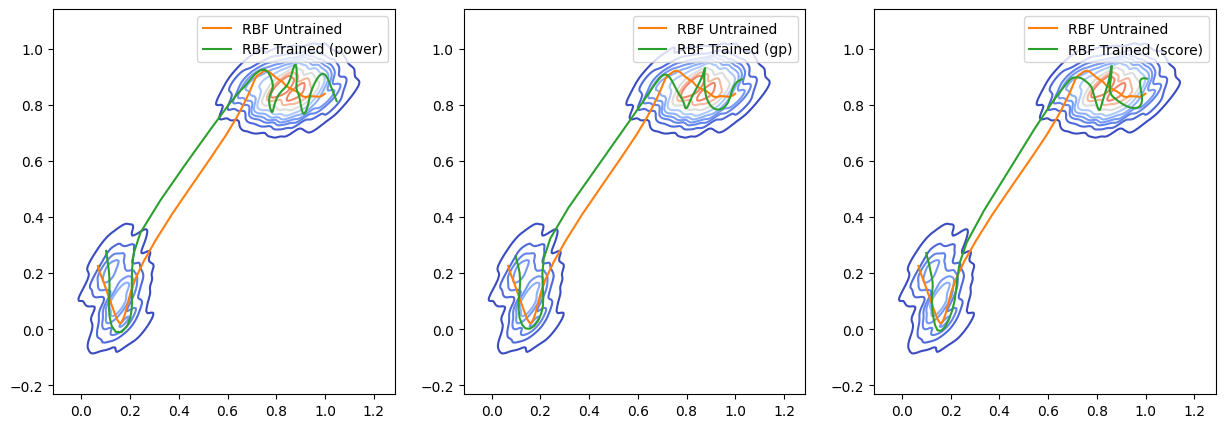

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

bw_adjust = 0.4
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0])
sns.lineplot(x=rbf_mmd_untrained.w[:, 0], y=rbf_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[0], sort=False)
# sns.scatterplot(x=rbf_mmd_power_tr.w[:, 0], y=rbf_mmd_power_tr.w[:,1], label="RBF Trained (power)", ax=ax[0])
sns.lineplot(x=rbf_mmd_power_tr.w[:, 0], y=rbf_mmd_power_tr.w[:,1], label="RBF Trained (power)", ax=ax[0], sort=False)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1])
sns.lineplot(x=rbf_mmd_untrained.w[:, 0], y=rbf_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[1], sort=False)
# sns.scatterplot(x=rbf_mmd_gp_tr.w[:, 0], y=rbf_mmd_gp_tr.w[:,1], label="RBF Trained (gp)", ax=ax[1])
sns.lineplot(x=rbf_mmd_gp_tr.w[:, 0], y=rbf_mmd_gp_tr.w[:,1], label="RBF Trained (gp)", ax=ax[1], sort=False)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[2])
sns.lineplot(x=rbf_mmd_untrained.w[:, 0], y=rbf_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[2], sort=False)
# sns.scatterplot(x=rbf_mmd_lgcp_tr.w[:, 0], y=rbf_mmd_lgcp_tr.w[:,1], label="RBF Trained (lgcp)", ax=ax[2])
sns.lineplot(x=rbf_mmd_score_tr.w[:, 0], y=rbf_mmd_score_tr.w[:,1], label="RBF Trained (score)", ax=ax[2], sort=False)

In [68]:
#### optax training
epochs = 2000
rbf_mmd_untrained, rbf_mmd_untrained_loss = train_mmd(
    key, rbf_mmd_init, gmm_samples, epochs=epochs, aux_loss=traj_loss_fn, optimizer="optax"
)
rbf_mmd_power_tr, rbf_mmd_power_loss = train_mmd(
    key, rbf_mmd_power, gmm_samples, epochs=epochs, aux_loss=traj_loss_fn, optimizer="optax"
)
rbf_mmd_gp_tr, rbf_mmd_gp_loss = train_mmd(
    key, rbf_mmd_gp, gmm_samples, epochs=epochs, aux_loss=traj_loss_fn, optimizer="optax"
)
rbf_mmd_score_tr, rbf_mmd_score_state_tr = train_mmd(
    key, rbf_mmd_score, gmm_samples, epochs=epochs, aux_loss=traj_loss_fn, optimizer="optax"
)

<Axes: >

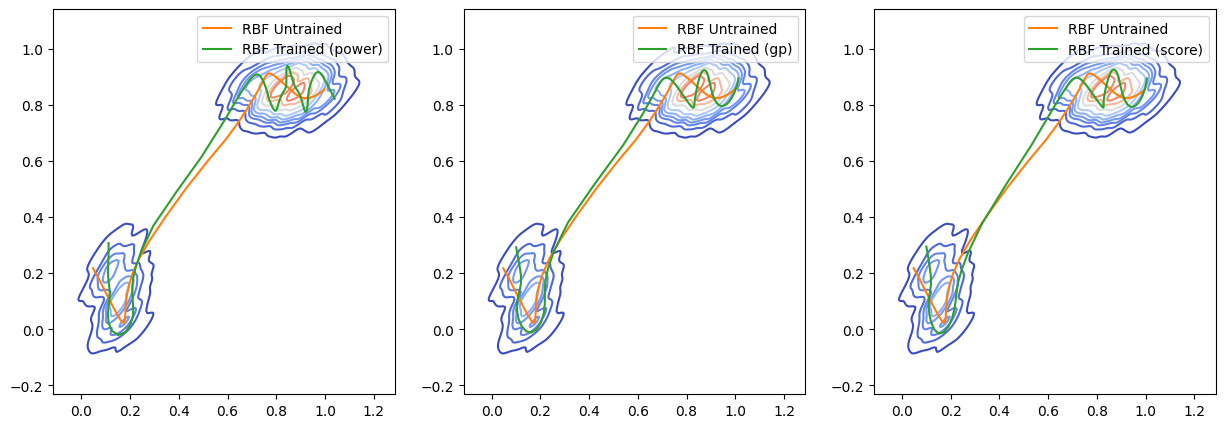

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

bw_adjust = 0.4
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0])
sns.lineplot(x=rbf_mmd_untrained.w[:, 0], y=rbf_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[0], sort=False)
sns.lineplot(x=rbf_mmd_power_tr.w[:, 0], y=rbf_mmd_power_tr.w[:,1], label="RBF Trained (power)", ax=ax[0], sort=False)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1])
sns.lineplot(x=rbf_mmd_untrained.w[:, 0], y=rbf_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[1], sort=False)
# sns.scatterplot(x=rbf_mmd_gp_tr.w[:, 0], y=rbf_mmd_gp_tr.w[:,1], label="RBF Trained (gp)", ax=ax[1])
sns.lineplot(x=rbf_mmd_gp_tr.w[:, 0], y=rbf_mmd_gp_tr.w[:,1], label="RBF Trained (gp)", ax=ax[1], sort=False)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[2])
sns.lineplot(x=rbf_mmd_untrained.w[:, 0], y=rbf_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[2], sort=False)
sns.lineplot(x=rbf_mmd_score_tr.w[:, 0], y=rbf_mmd_score_tr.w[:,1], label="RBF Trained (score)", ax=ax[2], sort=False)

<Axes: >

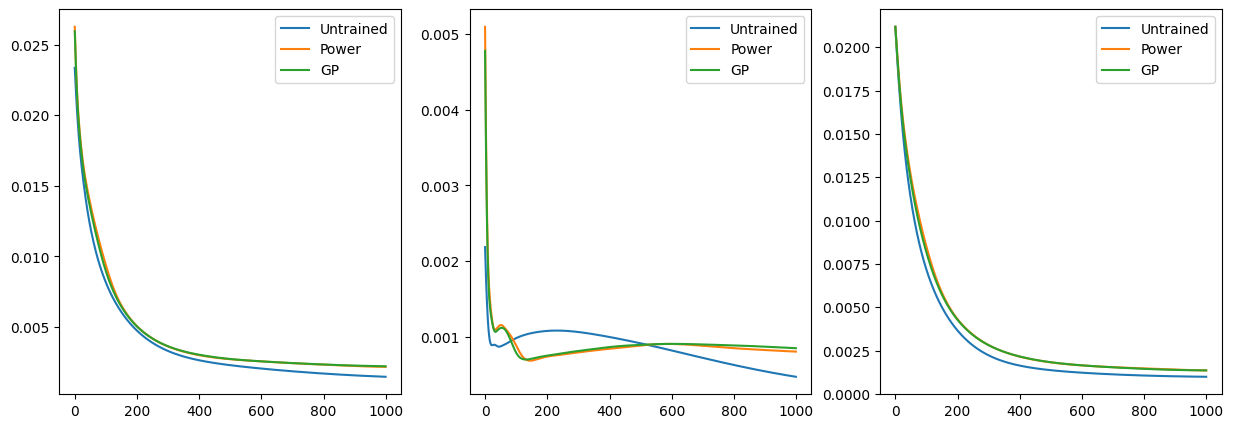

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.lineplot(x=jnp.arange(len(rbf_mmd_untrained_loss[:, 0])), y=rbf_mmd_untrained_loss[:, 0], label="Untrained", ax=ax[0])
sns.lineplot(x=jnp.arange(len(rbf_mmd_power_loss[:, 0])), y=rbf_mmd_power_loss[:, 0], label="Power", ax=ax[0])
sns.lineplot(x=jnp.arange(len(rbf_mmd_gp_loss[:, 0])), y=rbf_mmd_gp_loss[:, 0], label="GP", ax=ax[0])

sns.lineplot(x=jnp.arange(len(rbf_mmd_untrained_loss[:, 1])), y=rbf_mmd_untrained_loss[:, 1], label="Untrained", ax=ax[1])
sns.lineplot(x=jnp.arange(len(rbf_mmd_power_loss[:, 1])), y=rbf_mmd_power_loss[:, 1], label="Power", ax=ax[1])
sns.lineplot(x=jnp.arange(len(rbf_mmd_gp_loss[:, 1])), y=rbf_mmd_gp_loss[:, 1], label="GP", ax=ax[1])

sns.lineplot(x=jnp.arange(len(rbf_mmd_untrained_loss[:, 2])), y=rbf_mmd_untrained_loss[:, 2], label="Untrained", ax=ax[2])
sns.lineplot(x=jnp.arange(len(rbf_mmd_power_loss[:, 2])), y=rbf_mmd_power_loss[:, 2], label="Power", ax=ax[2])
sns.lineplot(x=jnp.arange(len(rbf_mmd_gp_loss[:, 2])), y=rbf_mmd_gp_loss[:, 2], label="GP", ax=ax[2])

### RFF

In [ ]:
rff = Transform(ARD(jnp.ones(2) * ls_init), RFF(key, R=100, d=2))
rff_mmd_init = ImpCloudMMD(rff, traj_init)  # uniform px by default

epoch 0,loss: -0.716077856302078
epoch 100,loss: -0.4706374367514607
epoch 200,loss: -0.247152502573657
epoch 300,loss: -0.11486735177277695
epoch 400,loss: -0.0544075302280062
epoch 500,loss: -0.024842098673922345
epoch 600,loss: -0.007089797328252431
epoch 700,loss: 0.005303594762505643
epoch 800,loss: 0.01466329267759866
epoch 900,loss: 0.022006435600951686
epoch 1000,loss: 0.027890752361002448
epoch 1100,loss: 0.032721649823111695
epoch 1200,loss: 0.03683825894220295
epoch 1300,loss: 0.040536291116998906
epoch 1400,loss: 0.04405719560370384
epoch 1500,loss: 0.04752174167480984
epoch 1600,loss: 0.05097542184889936
epoch 1700,loss: 0.05443693347465827
epoch 1800,loss: 0.05723134425424814
epoch 1900,loss: 0.059681253295815966


<Axes: >

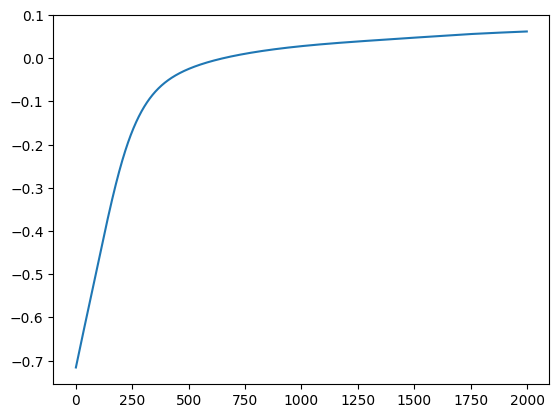

In [ ]:
rff_mmd_power, rff_loss_power = train_mmd_kernel(
    key, rff_mmd_init, gmm_samples, epochs=2000, to_train=lambda t: [t.k.transform.scale, t.k.kernel.w], 
    verbose=True, print_iter=100, shuffle=True, lr=1e-3
)
sns.lineplot(x=jnp.arange(len(rff_loss_power)), y=rff_loss_power)

epoch 0,loss: 144246759.32594755


epoch 100,loss: 118081907.6001878
epoch 200,loss: 101153471.40451539
epoch 300,loss: 92598137.88460305
epoch 400,loss: 85568346.24004242
epoch 500,loss: 76917579.46467125
epoch 600,loss: 63198781.02646687
epoch 700,loss: 50335962.44460147
epoch 800,loss: 41892866.78526309
epoch 900,loss: 31414714.60367693
epoch 1000,loss: 25331971.29048005
epoch 1100,loss: 21609927.57179652
epoch 1200,loss: 18571092.7960122
epoch 1300,loss: 16010619.405529171
epoch 1400,loss: 13469829.869418556
epoch 1500,loss: 11136517.917266127
epoch 1600,loss: 9149411.492273297
epoch 1700,loss: 7386610.595096289
epoch 1800,loss: 6235405.0978034735
epoch 1900,loss: 5604259.970305932
epoch 2000,loss: 5213774.008040618
epoch 2100,loss: 4789713.7321574865
epoch 2200,loss: 4186278.841606687
epoch 2300,loss: 3658759.6706390907
epoch 2400,loss: 3343109.965538429
epoch 2500,loss: 3080243.484315517
epoch 2600,loss: 2870623.69105505
epoch 2700,loss: 2733177.2649500864
epoch 2800,loss: 2624016.2418675786
epoch 2900,loss: 25150

<Axes: >

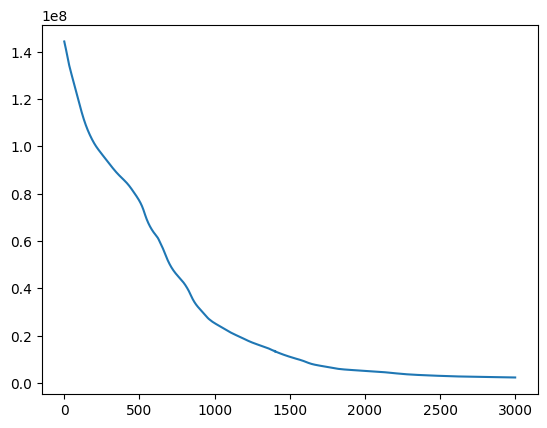

In [ ]:
rff_mmd_gp, rff_loss_gp = train_mmd_kernel_gp(
    key, rff_mmd_init, X, y, epochs=3000, to_train=lambda t: [t.k.transform.scale, t.k.kernel.w],
    verbose=True, print_iter=100, lr=1e-3, lowrank=True
)
sns.lineplot(x=jnp.arange(len(rff_loss_gp)), y=rff_loss_gp)

#### Make Trajectory

In [ ]:
#### jaxopt training
# opt_params = dict(tol=1e-5)
opt_params = None
_bounds = bounds
# _bounds = None

rff_mmd_untrained, rff_mmd_untrained_state = train_mmd(
    key, rff_mmd_init, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
rff_mmd_power_tr, rff_mmd_power_state_tr = train_mmd(
    key, rff_mmd_power, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
rff_mmd_gp_tr, rff_mmd_power_gp_tr = train_mmd(
    key, rff_mmd_gp, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)

{}
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 5.44846864304273e-05 Stepsize:1.0  Decrease Error:0.0  Curvature Error:5.44846864304273e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. c

<Axes: >

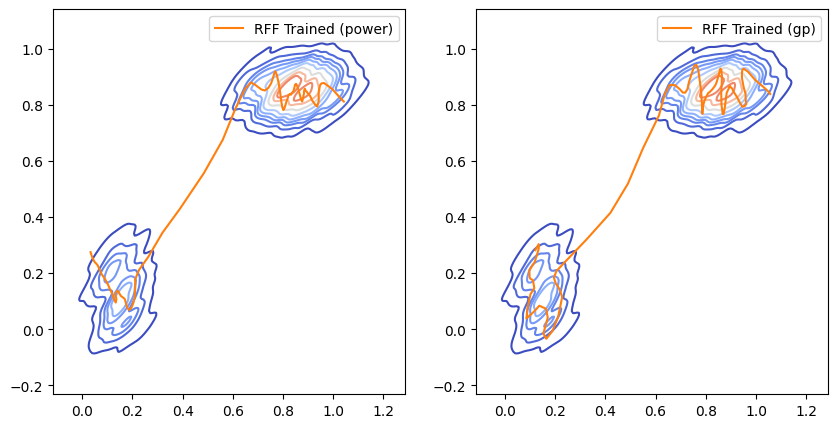

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bw_adjust = 0.4
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0])
# sns.lineplot(x=rff_mmd_untrained.w[:, 0], y=rff_mmd_untrained.w[:,1], label="RFF Untrained", ax=ax[0], sort=False)
sns.lineplot(x=rff_mmd_power_tr.w[:, 0], y=rff_mmd_power_tr.w[:,1], label="RFF Trained (power)", ax=ax[0], sort=False)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1])
# sns.lineplot(x=rff_mmd_untrained.w[:, 0], y=rff_mmd_untrained.w[:,1], label="RFF Untrained", ax=ax[1], sort=False)
sns.lineplot(x=rff_mmd_gp_tr.w[:, 0], y=rff_mmd_gp_tr.w[:,1], label="RFF Trained (gp)", ax=ax[1], sort=False)

In [ ]:
# #### optax training
# rff_mmd_untrained, rff_mmd_untrained_state = train_mmd(
#     key, rff_mmd_init, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
# )
# rff_mmd_power_tr, rff_mmd_power_state_tr = train_mmd(
#     key, rff_mmd_power, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
# )
# rff_mmd_gp_tr, rff_mmd_power_gp_tr = train_mmd(
#     key, rff_mmd_gp, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
# )

<Axes: >

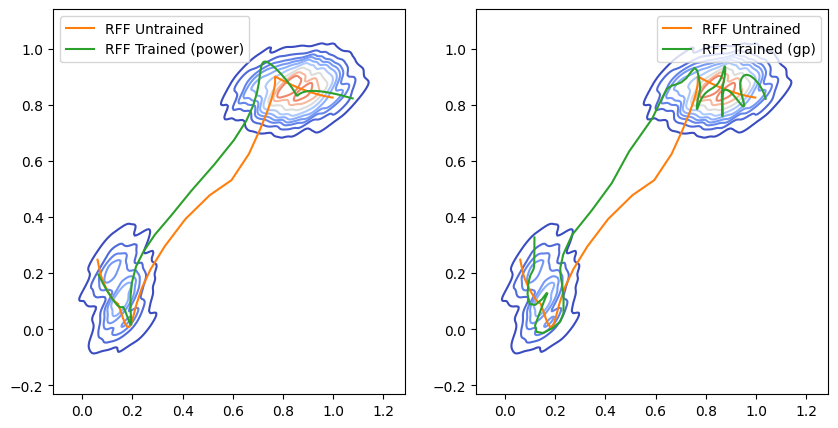

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bw_adjust = 0.4
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0])
sns.lineplot(x=rff_mmd_untrained.w[:, 0], y=rff_mmd_untrained.w[:,1], label="RFF Untrained", ax=ax[0], sort=False)
sns.lineplot(x=rff_mmd_power_tr.w[:, 0], y=rff_mmd_power_tr.w[:,1], label="RFF Trained (power)", ax=ax[0], sort=False)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1])
sns.lineplot(x=rff_mmd_untrained.w[:, 0], y=rff_mmd_untrained.w[:,1], label="RFF Untrained", ax=ax[1], sort=False)
sns.lineplot(x=rff_mmd_gp_tr.w[:, 0], y=rff_mmd_gp_tr.w[:,1], label="RFF Trained (gp)", ax=ax[1], sort=False)

### Deep Kernel

In [ ]:
# layers = [2, 10, 10, 10, 4]
dims = (2, 5)
d_hidden, n_hidden = (16, 4)

deepk = DeepCK(key, dims, d_hidden=d_hidden, n_hidden=n_hidden, ls=ls_init)
deep_mmd_init = ImpCloudMMD(deepk, traj_init)  # uniform px by default
deep_param_fn = lambda t: [
    t.k.nnk.transform.layers, t.k.nnk.transform.scale, t.k.ck.transform.scale, t.k.epsilon
]
# deep_param_fn = lambda t: [t.k.nnk.transform.layers, t.k.nnk.transform.scale]

epoch 0,loss: -0.7118811721892983


epoch 100,loss: -0.35865394234986686
epoch 200,loss: -0.1518935327237798
epoch 300,loss: -0.09677659095370308
epoch 400,loss: 0.03052636936752713
epoch 500,loss: 0.08737095689240851
epoch 600,loss: 0.1543153465486753
epoch 700,loss: 0.1850830333357889
epoch 800,loss: 0.2048585987285514
epoch 900,loss: 0.2147656622752969
epoch 1000,loss: 0.224209944688882
epoch 1100,loss: 0.23557296863019808
epoch 1200,loss: 0.24393355288441754
epoch 1300,loss: 0.2530034014468468
epoch 1400,loss: 0.26858135166580793
epoch 1500,loss: 0.2810704864050177
epoch 1600,loss: 0.2890192061279888
epoch 1700,loss: 0.29925920477458545
epoch 1800,loss: 0.3076310899068954
epoch 1900,loss: 0.31180770053207124
epoch 2000,loss: 0.32178760417963814
epoch 2100,loss: 0.3267169623518114
epoch 2200,loss: 0.3320401289593615
epoch 2300,loss: 0.33581825315744496
epoch 2400,loss: 0.3395307346960304
epoch 2500,loss: 0.34814648225360556
epoch 2600,loss: 0.35120273539518304
epoch 2700,loss: 0.35615655181757155
epoch 2800,loss: 0.35

<Axes: >

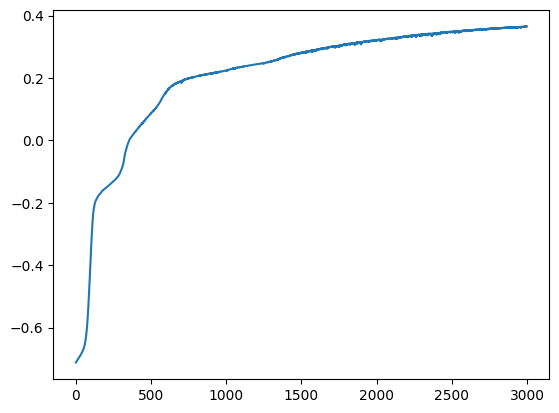

In [ ]:
deep_mmd_power, deep_loss_power = train_mmd_kernel(
    key, deep_mmd_init, gmm_samples, epochs=3000, to_train=deep_param_fn, 
    verbose=True, print_iter=100, shuffle=True, lr=1e-3
)
sns.lineplot(x=jnp.arange(len(deep_loss_power)), y=deep_loss_power)

epoch 0,loss: 63691983.024485655
epoch 100,loss: 29148036.603172403
epoch 200,loss: 12174092.472662207
epoch 300,loss: 7702991.727490593
epoch 400,loss: 4392154.577292468
epoch 500,loss: 2698946.9794990392
epoch 600,loss: 1994899.694217955
epoch 700,loss: 1533975.9710462233
epoch 800,loss: 1208148.270950881
epoch 900,loss: 975710.7287882561
epoch 1000,loss: 802026.5658015242
epoch 1100,loss: 675670.352277005
epoch 1200,loss: 576609.1821113446
epoch 1300,loss: 497898.9822827484
epoch 1400,loss: 440183.70175900107
epoch 1500,loss: 394620.02495376574
epoch 1600,loss: 353513.4088940533
epoch 1700,loss: 322622.96998504543
epoch 1800,loss: 295701.03120261506
epoch 1900,loss: 273342.56063923636
epoch 2000,loss: 250245.3556112778
epoch 2100,loss: 229523.97991640412
epoch 2200,loss: 210390.1944283719
epoch 2300,loss: 192482.94261199166
epoch 2400,loss: 173731.74360451783
epoch 2500,loss: 152718.71333663593
epoch 2600,loss: 136983.27594098359
epoch 2700,loss: 125308.246535689
epoch 2800,loss: 11

<Axes: >

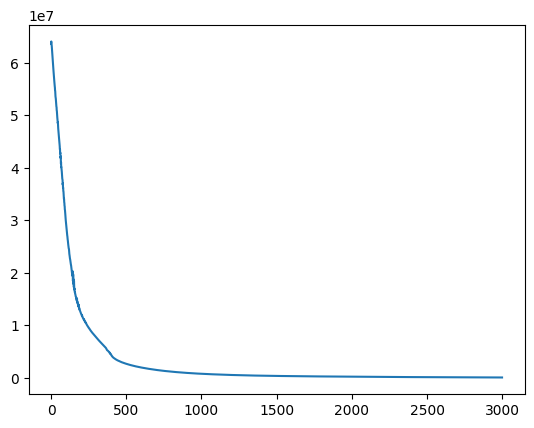

In [ ]:
deep_mmd_gp, deep_loss_gp = train_mmd_kernel_gp(
    key, deep_mmd_init, X, y, epochs=3000, to_train=deep_param_fn,
    verbose=True, print_iter=100, lr=1e-3, lowrank=False
)
sns.lineplot(x=jnp.arange(len(deep_loss_gp)), y=deep_loss_gp)

#### Make Trajectory

In [ ]:
#### jaxopt training
# opt_params = dict(tol=1e-5)
opt_params = None
_bounds = bounds
# _bounds = None

deep_mmd_untrained, deep_mmd_untrained_state = train_mmd(
    key, deep_mmd_init, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
deep_mmd_power_tr, deep_mmd_power_state_tr = train_mmd(
    key, deep_mmd_power, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
deep_mmd_gp_tr, deep_mmd_power_gp_tr = train_mmd(
    key, deep_mmd_gp, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)

{}
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 5.598548480191274e-05 Stepsize:1.0  Decrease Error:0.0  Curvature Error:5.598548480191274e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
{}
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (st

<Axes: >

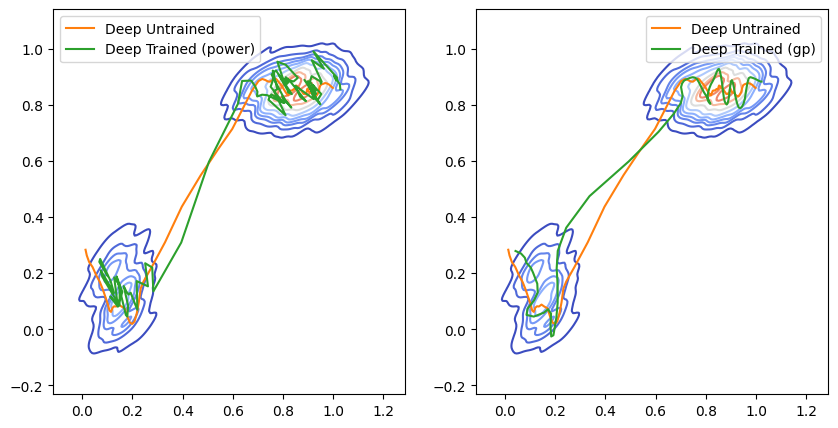

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bw_adjust = 0.4
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[0], sort=False)
sns.lineplot(x=deep_mmd_power_tr.w[:, 0], y=deep_mmd_power_tr.w[:,1], label="Deep Trained (power)", ax=ax[0], sort=False)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[1], sort=False)
sns.lineplot(x=deep_mmd_gp_tr.w[:, 0], y=deep_mmd_gp_tr.w[:,1], label="Deep Trained (gp)", ax=ax[1], sort=False)

In [ ]:
#### optax training
deep_mmd_untrained, deep_mmd_untrained_loss = train_mmd(
    key, deep_mmd_init, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
)
deep_mmd_power_tr, deep_mmd_power_loss = train_mmd(
    key, deep_mmd_power, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
)
deep_mmd_gp_tr, deep_mmd_power_gp_tr = train_mmd(
    key, deep_mmd_gp, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
)

<Axes: >

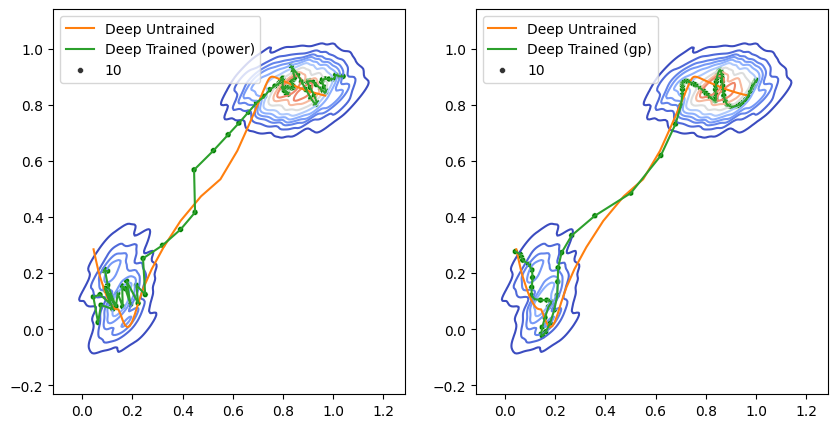

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bw_adjust = 0.4
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[0], sort=False)
sns.lineplot(x=deep_mmd_power_tr.w[:, 0], y=deep_mmd_power_tr.w[:,1], label="Deep Trained (power)", ax=ax[0], sort=False)
sns.scatterplot(x=deep_mmd_power_tr.w[:, 0], y=deep_mmd_power_tr.w[:,1], ax=ax[0], c='green', size=10)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[1], sort=False)
sns.lineplot(x=deep_mmd_gp_tr.w[:, 0], y=deep_mmd_gp_tr.w[:,1], label="Deep Trained (gp)", ax=ax[1], sort=False)
sns.scatterplot(x=deep_mmd_gp_tr.w[:, 0], y=deep_mmd_gp_tr.w[:,1], ax=ax[1], c='green', size=10)

### Comparison Plots

<Axes: >

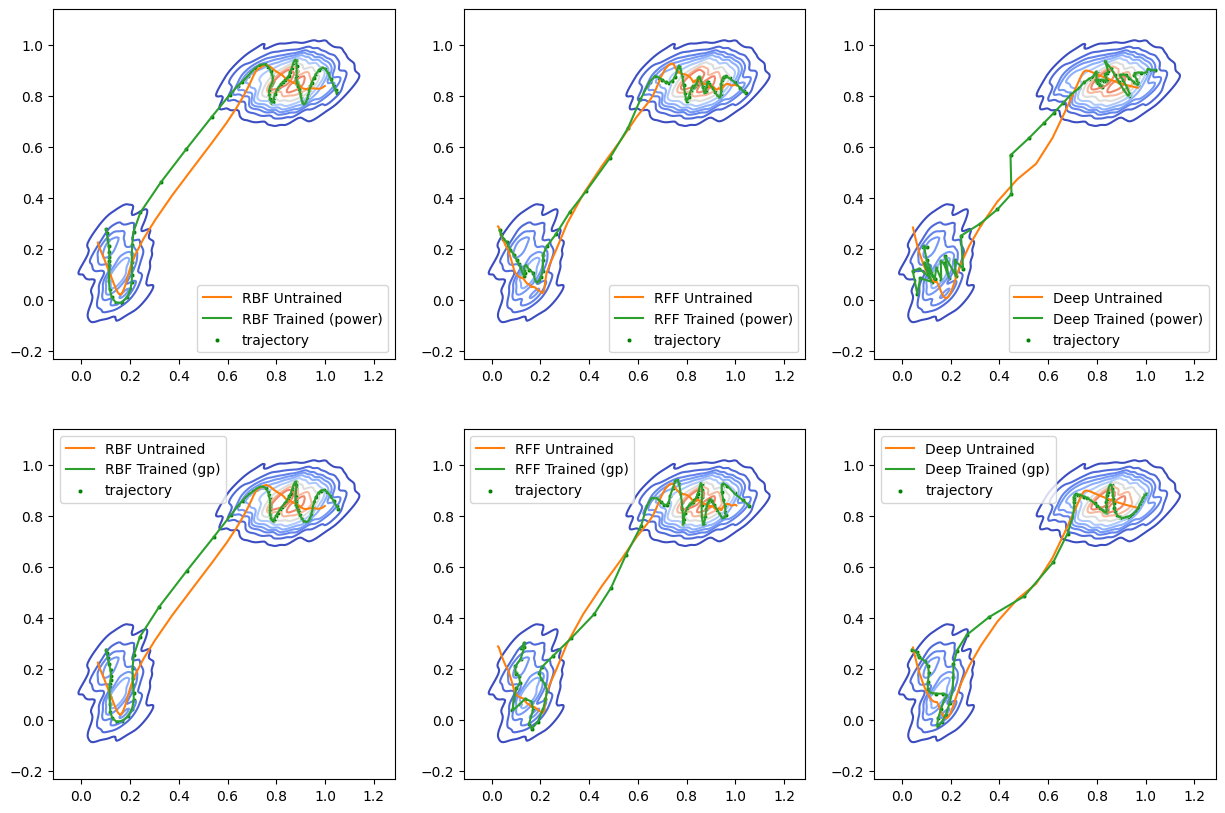

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

bw_adjust = 0.4

## rbf
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0, 0])
sns.lineplot(x=rbf_mmd_untrained.w[:, 0], y=rbf_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[0, 0], sort=False)
sns.lineplot(x=rbf_mmd_power_tr.w[:, 0], y=rbf_mmd_power_tr.w[:,1], label="RBF Trained (power)", ax=ax[0, 0], sort=False)
sns.scatterplot(x=rbf_mmd_power_tr.w[:, 0], y=rbf_mmd_power_tr.w[:,1], ax=ax[0, 0], c='green', label="trajectory", s=10)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1, 0])
sns.lineplot(x=rbf_mmd_untrained.w[:, 0], y=rbf_mmd_untrained.w[:,1], label="RBF Untrained", ax=ax[1, 0], sort=False)
sns.lineplot(x=rbf_mmd_gp_tr.w[:, 0], y=rbf_mmd_gp_tr.w[:,1], label="RBF Trained (gp)", ax=ax[1, 0], sort=False)
sns.scatterplot(x=rbf_mmd_gp_tr.w[:, 0], y=rbf_mmd_gp_tr.w[:,1], ax=ax[1, 0], c='green', label="trajectory", s=10)

# rff
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0, 1])
sns.lineplot(x=rff_mmd_untrained.w[:, 0], y=rff_mmd_untrained.w[:,1], label="RFF Untrained", ax=ax[0, 1], sort=False)
sns.lineplot(x=rff_mmd_power_tr.w[:, 0], y=rff_mmd_power_tr.w[:,1], label="RFF Trained (power)", ax=ax[0, 1], sort=False)
sns.scatterplot(x=rff_mmd_power_tr.w[:, 0], y=rff_mmd_power_tr.w[:,1], ax=ax[0, 1], c='green', label="trajectory", s=10)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1, 1])
sns.lineplot(x=rff_mmd_untrained.w[:, 0], y=rff_mmd_untrained.w[:,1], label="RFF Untrained", ax=ax[1, 1], sort=False)
sns.lineplot(x=rff_mmd_gp_tr.w[:, 0], y=rff_mmd_gp_tr.w[:,1], label="RFF Trained (gp)", ax=ax[1, 1], sort=False)
sns.scatterplot(x=rff_mmd_gp_tr.w[:, 0], y=rff_mmd_gp_tr.w[:,1], ax=ax[1, 1], c='green', label="trajectory", s=10)

## deep kernel
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0,2])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[0,2], sort=False)
sns.lineplot(x=deep_mmd_power_tr.w[:, 0], y=deep_mmd_power_tr.w[:,1], label="Deep Trained (power)", ax=ax[0,2], sort=False)
sns.scatterplot(x=deep_mmd_power_tr.w[:, 0], y=deep_mmd_power_tr.w[:,1], ax=ax[0,2], c='green', label="trajectory", s=10)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1,2])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[1,2], sort=False)
sns.lineplot(x=deep_mmd_gp_tr.w[:, 0], y=deep_mmd_gp_tr.w[:,1], label="Deep Trained (gp)", ax=ax[1,2], sort=False)
sns.scatterplot(x=deep_mmd_gp_tr.w[:, 0], y=deep_mmd_gp_tr.w[:,1], ax=ax[1,2], c='green', label="trajectory", s=10)

## Bunny

In [9]:
import pyvista as pv
import jraph

pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb(wait=5)

In [10]:
bunny_o3d = o3d.data.BunnyMesh()
bunny = o3d_mesh_to_pv(bunny_o3d)
bunny_graph = o3d_mesh_to_graph(bunny_o3d)

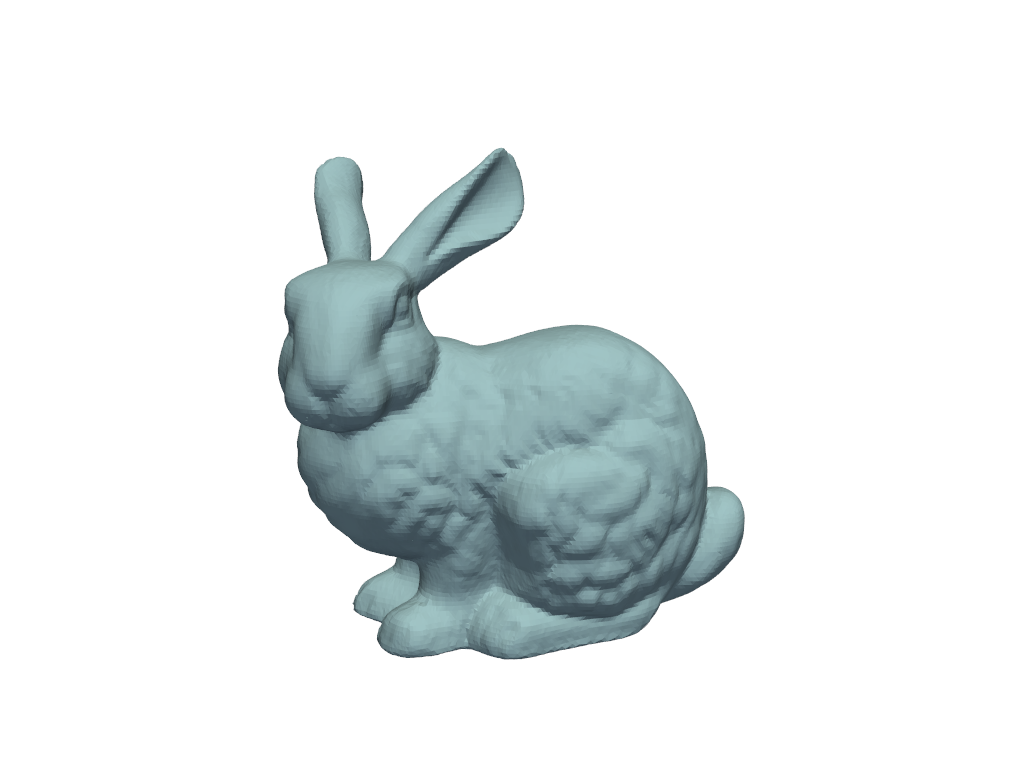

In [11]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(bunny, show_edges=False)
pl.camera.roll = 0
pl.camera.elevation = -20
pl.camera.azimuth = -55
pl.show(jupyter_backend='pythreejs')

### GNN Kernel

In [12]:
from emmd.transforms import GATLayer

In [13]:
gat = GATLayer(key, (3, 10))

In [14]:
gat_out = gat(key, bunny_graph)

In [16]:
gat_out.nodes.shape

(35947, 10)

In [ ]:
# layers = [2, 10, 10, 10, 4]
dims = (2, 5)
d_hidden, n_hidden = (16, 4)

deepk = DeepCK(key, dims, d_hidden=d_hidden, n_hidden=n_hidden, ls=ls_init)
deep_mmd_init = ImpCloudMMD(deepk, traj_init)  # uniform px by default
deep_param_fn = lambda t: [
    t.k.nnk.transform.layers, t.k.nnk.transform.scale, t.k.ck.transform.scale, t.k.epsilon
]
# deep_param_fn = lambda t: [t.k.nnk.transform.layers, t.k.nnk.transform.scale]

In [ ]:
gmm_samples_graph = knn_graph(gmm_samples, k=5)
traj_init_graph = trajectory_graph(traj_init, directed=True)

In [ ]:
thing = knn_graph(gmm_samples, k=5, directed=True)

In [ ]:
thing.shape

(5000, 2)

<Axes: >

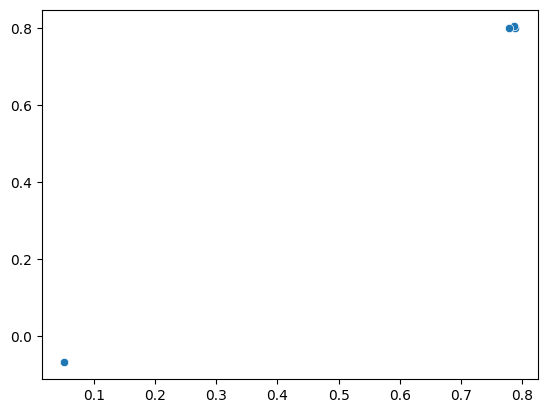

In [ ]:
pts = jnp.array([0, 1, 736, 531])
sns.scatterplot(x=gmm_samples[pts, 0], y=gmm_samples[pts, 1])

In [ ]:
thing.argsort(axis=-1)[:, -1]

Array([531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531,
       531, 531, 755, 531, 531, 531, 755, 531, 755, 531, 755, 755, 531,
       531, 531, 755, 531, 531, 531, 531, 531, 531, 531, 531, 531, 755,
       531, 531, 531, 531, 531, 531, 531, 755, 531, 531, 531, 755, 531,
       531, 531, 531, 531, 531, 755, 755, 531, 531, 531, 531, 531, 531,
       531, 755, 531, 755,  97, 531, 531, 531, 531, 755, 531, 755, 531,
       755, 531, 531, 531, 531, 531, 531, 832, 755, 531, 755, 755, 755,
       755, 531, 531, 531, 531, 531, 531, 755, 531, 755, 531, 755, 755,
       755, 531, 531, 755, 531, 531, 531, 531, 531, 755, 755, 531, 531,
       755, 531, 531, 755, 531, 755,  97, 755, 531, 755, 531, 531, 531,
       755, 755, 531, 531, 531, 531, 531, 531, 755, 755, 531, 531, 832,
       755, 755, 531, 755, 531, 755, 531, 755, 531, 755, 755, 531, 531,
       531, 531, 531, 755, 531, 531, 755, 755, 531, 531, 531, 755, 755,
       755, 531, 755, 531, 531, 531, 531, 531, 531, 531, 531, 53

In [ ]:
traj_graph_init = trajectory_graph(traj_init)

In [ ]:
#### jaxopt training
# opt_params = dict(tol=1e-5)
opt_params = None
_bounds = bounds
# _bounds = None

deep_mmd_untrained, deep_mmd_untrained_state = train_mmd(
    key, deep_mmd_init, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
deep_mmd_power_tr, deep_mmd_power_state_tr = train_mmd(
    key, deep_mmd_power, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)
deep_mmd_gp_tr, deep_mmd_power_gp_tr = train_mmd(
    key, deep_mmd_gp, gmm_samples, _bounds, aux_loss=traj_loss_fn, opt_params=opt_params
)

{}
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 5.598548480191274e-05 Stepsize:1.0  Decrease Error:0.0  Curvature Error:5.598548480191274e-05 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
{}
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (st

<Axes: >

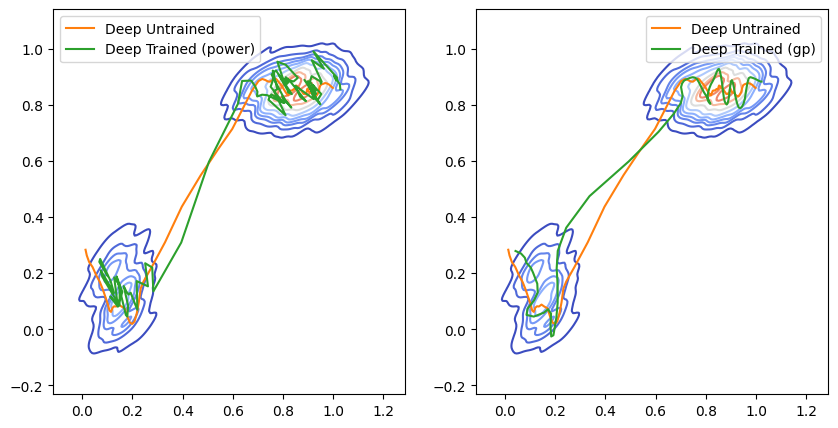

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bw_adjust = 0.4
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[0], sort=False)
sns.lineplot(x=deep_mmd_power_tr.w[:, 0], y=deep_mmd_power_tr.w[:,1], label="Deep Trained (power)", ax=ax[0], sort=False)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[1], sort=False)
sns.lineplot(x=deep_mmd_gp_tr.w[:, 0], y=deep_mmd_gp_tr.w[:,1], label="Deep Trained (gp)", ax=ax[1], sort=False)

In [ ]:
#### optax training
deep_mmd_untrained, deep_mmd_untrained_loss = train_mmd(
    key, deep_mmd_init, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
)
deep_mmd_power_tr, deep_mmd_power_loss = train_mmd(
    key, deep_mmd_power, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
)
deep_mmd_gp_tr, deep_mmd_power_gp_tr = train_mmd(
    key, deep_mmd_gp, gmm_samples, epochs=1000, aux_loss=traj_loss_fn, optimizer="optax"
)

<Axes: >

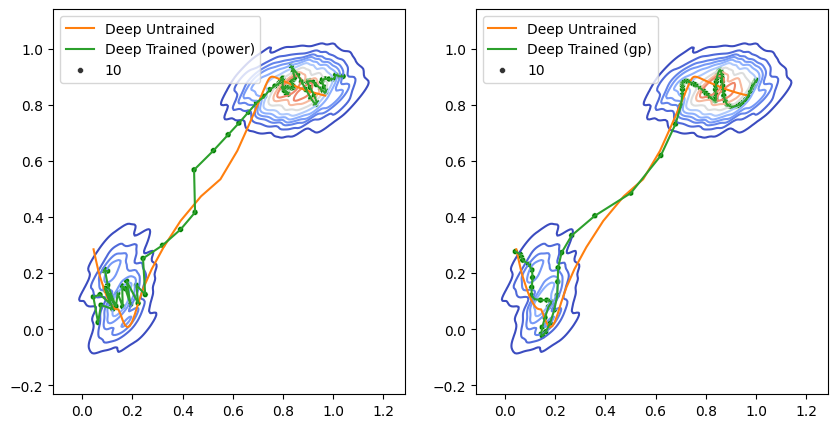

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bw_adjust = 0.4
sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[0])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[0], sort=False)
sns.lineplot(x=deep_mmd_power_tr.w[:, 0], y=deep_mmd_power_tr.w[:,1], label="Deep Trained (power)", ax=ax[0], sort=False)
sns.scatterplot(x=deep_mmd_power_tr.w[:, 0], y=deep_mmd_power_tr.w[:,1], ax=ax[0], c='green', size=10)

sns.kdeplot(x=gmm_samples[:, 0], y=gmm_samples[:, 1], bw_adjust=bw_adjust, cmap=cm.coolwarm, ax=ax[1])
sns.lineplot(x=deep_mmd_untrained.w[:, 0], y=deep_mmd_untrained.w[:,1], label="Deep Untrained", ax=ax[1], sort=False)
sns.lineplot(x=deep_mmd_gp_tr.w[:, 0], y=deep_mmd_gp_tr.w[:,1], label="Deep Trained (gp)", ax=ax[1], sort=False)
sns.scatterplot(x=deep_mmd_gp_tr.w[:, 0], y=deep_mmd_gp_tr.w[:,1], ax=ax[1], c='green', size=10)